In [14]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import os
from rasterstats import zonal_stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from shapely.errors import ShapelyDeprecationWarning
from glob import glob
from rioxarray.merge import merge_arrays
import rasterio
from shapely.geometry import Polygon, Point
import random
import shutil
import importlib
import pandas as pd
from glob import glob
#suppress ShapelyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

def recreate_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def load_config(path):
    spec = importlib.util.spec_from_file_location("CFG", path)
    CFG = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(CFG)
    return CFG

In [15]:
DATA_DIR = "data/20221220_Sudol"
CFG = load_config(f"{DATA_DIR}/config.py").EXPLORATION

CACHE_DIR = f"{DATA_DIR}/cache"
GEOTIF_UNCAL_DIR = f"{DATA_DIR}/geotif_uncal"
GEOTIF_CAL_DIR = f"{DATA_DIR}/geotif_cal"
CENTERLINE_PATH = f"{DATA_DIR}/centerline.json"

In [16]:
#open data/centerline.json
centerline = gpd.read_file(CENTERLINE_PATH)
#reproject centerline to 'epsg:32634'
centerline = centerline.to_crs(CFG.CRS)
#generate points along centerline every 0.1 meters
distance_delta = 5
distances = np.arange(0, centerline.length[0], distance_delta)
points = [centerline.geometry.interpolate(distance)[0] for distance in distances]
river_pts_gdf = gpd.GeoDataFrame({'geometry': points, 'chainage': distances}, crs=CFG.CRS)
#buffer points to 0.1 meters
river_pts_gdf["geometry"] = river_pts_gdf.buffer(CFG.CENTERLINE_POINTS_BUFFER)

In [17]:
if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/exploration_uncal.pkl"):
    df_uncal = pd.read_pickle(f"{CACHE_DIR}/exploration_uncal.pkl")
else:
    temperatures = []
    chainages = []
    times = []
    names = [name for name in os.listdir(GEOTIF_UNCAL_DIR) if name.endswith(".tif") ]
    for name in tqdm(names):
        time = datetime.strptime(name.split("_")[1], "%Y%m%d%H%M%S")
        raster = rxr.open_rasterio(f"{GEOTIF_UNCAL_DIR}/{name}")
        stats = zonal_stats(river_pts_gdf['geometry'], raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)
        for j, stat in enumerate(stats):
            if stat["mean"] != None:
                if stat["mean"] < raster.rio.nodata:
                    print(name)
                temperatures.append(stat["mean"])
                chainages.append(river_pts_gdf["chainage"][j])
                times.append(time)
    timestamps = [(time.timestamp() - min(times).timestamp())/60 for time in times]
    df_uncal = pd.DataFrame({"temperature": temperatures, "chainage": chainages, "time": timestamps})
    df_uncal.to_pickle(f"{CACHE_DIR}/exploration_uncal.pkl")

In [18]:
temperatures = []
chainages = []
times = []
names = [name for name in os.listdir(GEOTIF_CAL_DIR) if name.endswith(".tif") ]
for name in tqdm(names):
    time = datetime.strptime(name.split("_")[1], "%Y%m%d%H%M%S")
    raster = rxr.open_rasterio(f"{GEOTIF_CAL_DIR}/{name}")
    stats = zonal_stats(river_pts_gdf['geometry'], raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)
    for j, stat in enumerate(stats):
        if stat["mean"] != None:
            if stat["mean"] < raster.rio.nodata:
                print(name)
            temperatures.append(stat["mean"])
            chainages.append(river_pts_gdf["chainage"][j])
            times.append(time)
timestamps = [(time.timestamp() - min(times).timestamp())/60 for time in times]
df_cal = pd.DataFrame({"temperature": temperatures, "chainage": chainages, "time": timestamps})

100%|██████████| 891/891 [08:12<00:00,  1.81it/s]


In [19]:
#calculate mean and std of temperature for each chainage for uncalibrated and calibrated
uncalibrated_means = df_uncal.groupby("chainage").mean()["temperature"]
calibrated_means = df_cal.groupby("chainage").mean()["temperature"]
uncalibrated_stds = df_uncal.groupby("chainage").std()["temperature"]
calibrated_stds = df_cal.groupby("chainage").std()["temperature"]
print(uncalibrated_stds.mean())
print(calibrated_stds.mean())

0.9493131368877656
0.5084846389280827


In [20]:
valid_chainages = calibrated_stds[calibrated_stds < 1.0].index

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='chainage', ylabel='temperature'>

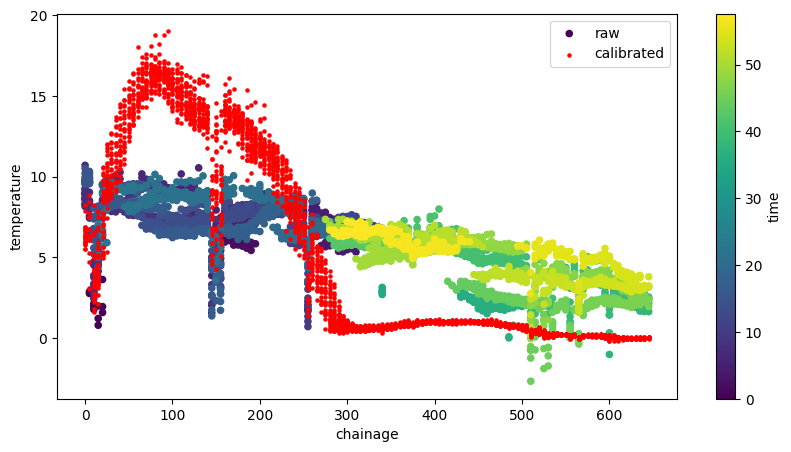

In [21]:
#plot temperature vs chainage vs time (color). Filter out chainages that are not in valid_chainages. Show legend.
fig, ax = plt.subplots(figsize=(10,5))
df_uncal.plot.scatter(x="chainage", y="temperature", c="time", colormap="viridis", ax=ax, label="raw")
df_cal.plot.scatter(x="chainage", y="temperature", c="red", colormap="viridis", ax=ax, label="calibrated", s=5)